In [706]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve, f1_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras

from imblearn.over_sampling import RandomOverSampler, SMOTE
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 17

In [707]:
df = pd.read_csv('data/train_df.csv', sep="\t")

# Overview

In [4]:
df

,Unnamed: 0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,cat_1,num_8,...,num_413,cat_132,cat_133,num_414,num_415,num_416,cat_134,cat_135,id,gb
0,0,1377.3,3712.9,NaN,1303.0,2409.0,1281.7,43.0,1,195.0,...,11327.5,1,1,28162496.65,0.0,0.07,1,1,1,0
1,1,20.0,13.4,NaN,565.0,NaN,357.2,19.0,1,170.0,...,168.6,1,1,989383.82,0.0,0.56,2,1,2,0
2,4,150.6,1.8,NaN,2294.0,15.0,107.6,76.0,1,196.0,...,209.1,1,1,87444.51,0.0,0.01,3,1,3,0
3,5,11.4,178.0,NaN,1236.0,NaN,350.6,41.0,1,117.0,...,56.9,1,1,297608.00,0.0,0.08,4,1,4,0
4,6,5372.0,3386.0,NaN,1340.0,NaN,14.0,45.0,1,9.0,...,31.0,1,1,6614247.89,0.0,0.20,1,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26819,61104,NaN,NaN,NaN,108.0,NaN,85.6,4.0,1,123.0,...,181.4,1,1,840801.82,0.0,0.09,7,1,5242,0
26820,61105,4.2,97.2,NaN,2149.0,130.5,409.3,72.0,1,157.0,...,596.7,1,1,557554.94,0.0,0.26,5,1,4320,0
26821,61108,4368.0,5004.0,NaN,2215.0,478.0,3176.0,74.0,1,381.0,...,0.0,1,2,17821295.19,0.0,0.37,3,1,2516,0
26822,61110,NaN,NaN,NaN,135.0,NaN,25.7,4.0,1,151.0,...,1494.9,1,1,7228675.60,0.0,0.00,4,1,4610,0


In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26824 entries, 0 to 26823
Data columns (total 554 columns):
 #    Column      Non-Null Count  Dtype  
---   ------      --------------  -----  
 0    Unnamed: 0  26824 non-null  int64  
 1    num_1       23028 non-null  float64
 2    num_2       22953 non-null  float64
 3    num_3       63 non-null     float64
 4    num_4       26816 non-null  float64
 5    num_5       17209 non-null  float64
 6    num_6       26824 non-null  float64
 7    num_7       26816 non-null  float64
 8    cat_1       26824 non-null  int64  
 9    num_8       26492 non-null  float64
 10   num_9       16364 non-null  float64
 11   num_10      21186 non-null  float64
 12   num_11      36 non-null     float64
 13   num_12      7816 non-null   float64
 14   num_13      26816 non-null  float64
 15   num_14      25860 non-null  float64
 16   num_15      26816 non-null  float64
 17   num_16      11530 non-null  float64
 18   num_17      10350 non-null  float64
 19   nu

Percentage of targets objects: 2.211%


0    26231
1      593
Name: gb, dtype: int64

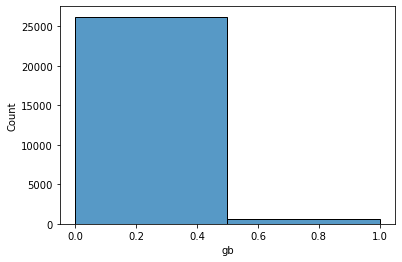

In [6]:
# visualize the distribution of the target category

sns.histplot(df['gb'], bins=2)
per_of_targets = (df['gb'].value_counts()[1] / len(df)) * 100
print(f"Percentage of targets objects: {round(per_of_targets, 3)}%")
df['gb'].value_counts()

Unnamed: 0    26824
num_1         23028
num_2         22953
num_3            63
num_4         26816
              ...  
num_416       26816
cat_134       26824
cat_135       26824
id            26824
gb            26824
Length: 554, dtype: int64

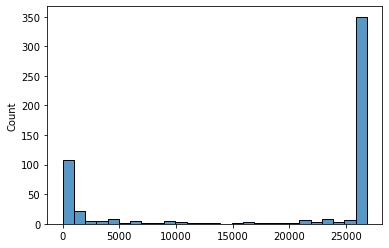

In [7]:
# vizualizate the number of Non-Null values
number_of_values = df.count(axis=0)
sns.histplot(number_of_values,bins=27)
number_of_values

#### The number of features that have less than 1000 Non-Null values greater than 100 from 553

Number of features without values: 12


num_3       63
num_11      36
num_18     535
num_20     445
num_21      62
          ... 
num_392      0
num_397     11
num_399    216
num_401    161
num_403    156
Length: 107, dtype: int64

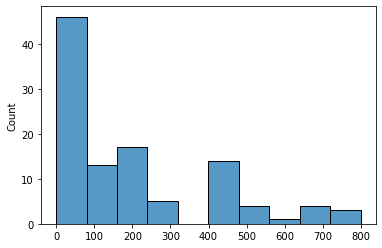

In [8]:
# visualize in more detail the number of values where the number of values is less than 1000
num_of_f_without_v = pd.Series(number_of_values).value_counts().get(0)
print(f"Number of features without values: {num_of_f_without_v}")
sns.histplot(number_of_values[number_of_values<1000],bins=10)
number_of_values[number_of_values<1000]

In [9]:
# select features that have from 100 to 200 number of values and see correlation with target 
features_100_200_values = number_of_values[(number_of_values>100) & (number_of_values<200)].index.to_list()
features_100_200_values.append('gb') # add target column
df[features_100_200_values].fillna(0).corr()

,num_49,num_89,num_90,num_91,num_99,num_103,num_108,num_121,num_135,num_142,num_143,num_166,num_223,num_326,num_348,num_362,num_363,num_401,num_403,gb
num_49,1.000000,-0.001713,0.900153,0.003360,-0.017286,-0.000314,-0.001684,0.396518,-0.001387,0.089098,0.047193,0.409292,-0.000537,0.015193,-0.000492,-0.000427,-0.000389,0.083740,0.047990,-0.005934
num_89,-0.001713,1.000000,-0.001719,-0.005331,0.002427,-0.000552,-0.001871,-0.001592,-0.001889,-0.000288,-0.000280,-0.001488,-0.000593,0.054874,-0.000552,-0.000597,-0.000754,-0.000575,-0.000541,0.004144
num_90,0.900153,-0.001719,1.000000,-0.000281,-0.019894,-0.000113,-0.001703,0.399110,-0.001364,0.086639,0.053464,0.411967,-0.000483,0.017477,-0.000209,-0.000405,-0.000577,0.079521,0.054181,-0.005955
num_91,0.003360,-0.005331,-0.000281,1.000000,0.001249,-0.000280,-0.000950,-0.000805,-0.000959,0.350396,-0.000462,-0.000752,-0.000301,-0.001057,-0.000281,-0.000303,-0.000383,0.329227,-0.000424,-0.003314
num_99,-0.017286,0.002427,-0.019894,0.001249,1.000000,0.000721,-0.005460,0.002077,-0.001350,0.002151,-0.006406,0.001942,0.000774,-0.309314,0.000721,0.000779,0.000978,0.001834,-0.006528,-0.210147
num_103,-0.000314,-0.000552,-0.000113,-0.000280,0.000721,1.000000,-0.000549,-0.000379,-0.000554,0.023687,-0.000269,-0.000346,-0.000174,-0.000610,0.998615,-0.000175,0.899763,-0.000405,-0.000249,-0.001914
num_108,-0.001684,-0.001871,-0.001703,-0.000950,-0.005460,-0.000549,1.000000,-0.000819,0.888136,-0.001636,-0.000914,-0.000691,-0.000589,0.022826,-0.000512,-0.000593,-0.000485,-0.001395,-0.000849,-0.006482
num_121,0.396518,-0.001592,0.399110,-0.000805,0.002077,-0.000379,-0.000819,1.000000,-0.000999,0.049306,0.104789,0.979584,-0.000471,-0.001759,-0.000339,-0.000471,-0.000618,0.047396,0.105306,-0.005513
num_135,-0.001387,-0.001889,-0.001364,-0.000959,-0.001350,-0.000554,0.888136,-0.000999,1.000000,-0.001652,-0.000923,-0.000876,-0.000595,0.016794,-0.000525,-0.000599,-0.000550,-0.001408,-0.000857,-0.006542
num_142,0.089098,-0.000288,0.086639,0.350396,0.002151,0.023687,-0.001636,0.049306,-0.001652,1.000000,0.013204,0.051012,-0.000221,-0.001821,0.021701,-0.000155,0.007995,0.972880,0.002932,-0.005708


<AxesSubplot:>

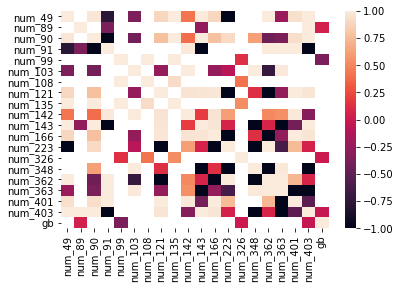

In [10]:
# heatmap for correlation
sns.heatmap(df[features_100_200_values].corr())

#### In this case, white reflects a correlation close to 0
#### Also, there are features that have high correlations like "num_49"/"num_90" and "num_143"/"num_403" 

# Print main metrics function

In [93]:
# Function for print main metrics for prediction
def print_scores(y_val, y_pred, is_proba=False, regulator=0.5):
    
    # Check if y_pred is the probability
    if (type(y_pred) == np.ndarray):
        if y_pred.dtype == np.floating:
            is_proba = True
    
    # Replace values if they are float
    if is_proba:
        # Rounding the prediction with the select threshold
        th_y_pred = np.where(np.array(y_pred) > regulator, 1, 0)
    else:
        th_y_pred = y_pred
    
    # Print scores
    accuracy = accuracy_score(y_val, th_y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, 
                                                                     th_y_pred, 
                                                                     average='binary')
    
    print(f"Accuracy score: {round(accuracy, 3)}")
    print(f"Precision score: {round(precision, 3)}")
    print(f"Recall score: {round(recall, 3)}")
    print(f"F-score: {round(f1_score, 3)}")
    
    # Plot and print the best threshold if y_pred are float
    if is_proba:
        # Calculate F1-Score for the thresholds
        f1_scores = list()
        precision_scores = list()
        recall_scores = list()
        threshold = np.linspace(0, 1, 100)

        for step in threshold:
            th_y_pred = np.where(np.array(y_pred) > step, 1, 0)
            precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, 
                                                                             th_y_pred,
                                                                             average='binary')
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1_score)
            

        # Drawing F1-Score for the thresholds
        ax = sns.lineplot(x=threshold, y=f1_scores)
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-Score')

        # Print the best F1-Score and the appropriate threshold
        print(f"\nMax F1-Score: {round(np.max(f1_scores), 3)} (threshold: {round(threshold[np.argmax(f1_scores)], 3)})\n")
        
    
    

# Baseline

### Split data

In [12]:
y = df['gb']
X = df.iloc[:, :-2]
X.fillna(value=0, inplace=True)

In [13]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

### Static prediction

In [14]:
# predict only "0" labels
y_pred = [0] * len(y_val)

# scores for only "0" labels
print_scores(y_val, y_pred)

Accuracy score: 0.976
Precision score: 0.0
Recall score: 0.0
F-score: 0.0


#### We see a high accuracy score because we have an imbalance of the target class.

##### So, we will use the F1 metric to evaluate the models.

### Logistic Regression

In [15]:
%%time
# Create and fit LinearRegression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

CPU times: user 9.94 s, sys: 402 ms, total: 10.3 s
Wall time: 3.91 s


LogisticRegression()

Accuracy score: 0.934
Precision score: 0.047
Recall score: 0.094
F-score: 0.063

Max F1-Score: 0.071 (threshold: 0.525)



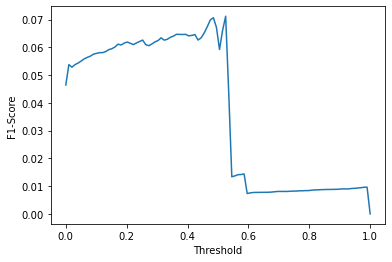

In [16]:
y_pred = lr_model.predict_proba(X_val)
print_scores(y_val, y_pred[:, 1])

#### For the base model, the metrics are very low.

### 2-dimensional representation

In [17]:
%%time
#Build a 2-dimensional representation
X_embedded = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(X)

CPU times: user 17min 10s, sys: 25.4 s, total: 17min 36s
Wall time: 2min 42s


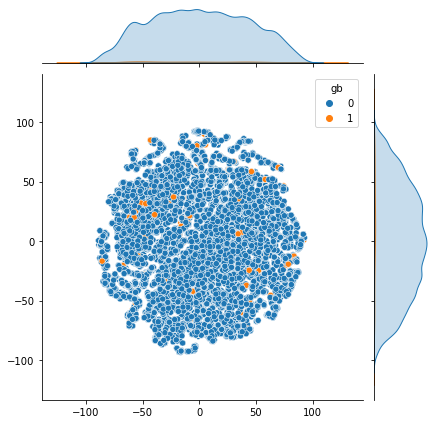

In [18]:
sns.jointplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y)

#### Objects of the target class are close to each other at several points.
#### So, it would be better to try the k-nearest neighbors algorithm for the base model.

In [19]:
%%time

kneighbors_model = KNeighborsClassifier()
kneighbors_model.fit(X_train, y_train)

CPU times: user 39.1 ms, sys: 19.9 ms, total: 59.1 ms
Wall time: 57.8 ms


KNeighborsClassifier()

Accuracy score: 0.981
Precision score: 0.676
Recall score: 0.361
F-score: 0.471

Max F1-Score: 0.562 (threshold: 0.202)



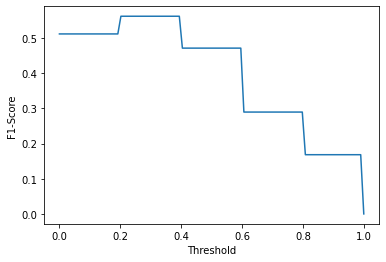

In [20]:
y_pred = kneighbors_model.predict_proba(X_val)
print_scores(y_val, y_pred[:, 1])

## For quick testing after changing df

! TEST !
DataFrame shape: (26824, 325)

X_train shape: (36748, 323)

Accuracy score: 0.976
Precision score: 0.497
Recall score: 0.754
F-score: 0.599

Max F1-Score: 0.751 (threshold: 0.808)

CPU times: user 18.5 s, sys: 3.83 s, total: 22.4 s
Wall time: 7.49 s


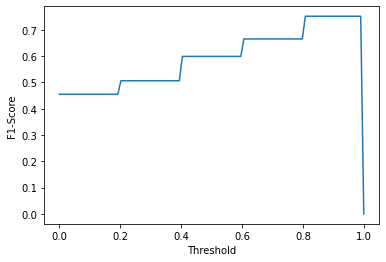

In [31]:
%%time

print("! TEST !")
print(f"DataFrame shape: {df2.shape}\n")

# For test df2
_y = df2['gb']
_X = df2.iloc[:, :-2]
_X.fillna(value=0, inplace=True)

# Split data
_X_train, _X_val, _y_train, _y_val = train_test_split(_X, 
                                                  _y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

# Test oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')
_X_train, _y_train = oversampler.fit_resample(_X_train, _y_train)
print(f"X_train shape: {_X_train.shape}\n")

# # Create SMOTE and resample X, y train
# smote = SMOTE(sampling_strategy='minority')
# _X_train, _y_train = smote.fit_resample(_X_train, _y_train)
# print(f"X_train shape: {_X_train.shape}\n")


# Train model
_kneighbors_model = KNeighborsClassifier()
_kneighbors_model.fit(_X_train, _y_train)

# Result
_y_pred = _kneighbors_model.predict_proba(_X_val)
print_scores(_y_val, _y_pred[:, 1])

# Clear data

In [32]:
df.shape

(26824, 554)

In [38]:
# Copy of dataframe for feature engineering
df2 = df.copy()

### Delete columns with a low number of values

In [39]:
print(f"DataFrame shape before deleting columns: {df2.shape}")

# select features that have less than 300 number of values and see correlation with target 

features_300_values = number_of_values[number_of_values<300].index.to_list()
features_300_values.append('gb') # add target column

corr_features_300 = df2[features_300_values].fillna(0).corr()['gb']
corr_features_300 = corr_features_300[:-1] # delete the self-correlated item

# Select features with small correlation and low number of values
small_corr_features_index = corr_features_300[abs(corr_features_300) < 0.05].index

# Drop this columns
df2.drop(columns=small_corr_features_index, inplace=True)

print(f"DataFrame shape after deleting columns: {df2.shape}")

DataFrame shape before deleting columns: (26824, 554)
DataFrame shape after deleting columns: (26824, 488)


### Delete columns with a highly correlated features

#### Only when used MinMaxScaler (For K-Nearest Neighbors) the result will be better

In [40]:
%%time

CORR_THRESHOLD = 0.95

print(f"DataFrame shape before deleting columns: {df2.shape}")

# Build a matrix of correlation features
cor_matrix = df2.iloc[:, :-2].corr()
# Select the Upper triangular matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# Select the column with high correlation
to_drop_index = [column for column in upper_tri.columns if any(upper_tri[column] > CORR_THRESHOLD)]

df2.drop(columns=to_drop_index, inplace=True)

print(f"DataFrame shape after deleting columns: {df2.shape}")

DataFrame shape before deleting columns: (26824, 488)
DataFrame shape after deleting columns: (26824, 325)
CPU times: user 10.6 s, sys: 91 ms, total: 10.7 s
Wall time: 10.7 s



### Replace each NaN value with zero.

In [41]:
df2.fillna(value=0, inplace=True)

# K-Nearest Neighbors

### Split and processed data

#### Since we have an imbalance of the target class and the minor class has only 600 objects, we will try to create more objects for the minor class (oversampling).

In [745]:
y = df2['gb']
X = df2.iloc[:, :-2]

print("X shape:")
print(X.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

print("\ny_train distribution:")
print(y_train.value_counts())
print("\ny_val distribution:")
print(y_val.value_counts())

# StandardScaler
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

# Normalizer (For KNeighborsClassifier result was worsened)
# normalizer = Normalizer().fit(X_train)
# X_train = normalizer.transform(X_train)
# X_val = normalizer.transform(X_val)

# MinMaxScaler (Improves the result)
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Random oversampling
# oversampler = RandomOverSampler(sampling_strategy='minority')
# X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

print("\ny_train_over:")
print(y_train_over.value_counts())

# SMOTE (For KNeighborsClassifier result was worsened)
# smote = SMOTE(sampling_strategy='minority')
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# 
# print("\ny_train_smote:")
# print(y_train_smote.value_counts())

X shape:
(26824, 323)

y_train distribution:
0    18374
1      402
Name: gb, dtype: int64

y_val distribution:
0    7857
1     191
Name: gb, dtype: int64

y_train_over:
1    18374
0    18374
Name: gb, dtype: int64


### Compare models

  0%|          | 0/10 [00:00<?, ?it/s]

Max score:
F-score raw data          0.846995
F-score processed data    0.030928
dtype: float64

CPU times: user 4min 17s, sys: 55.2 s, total: 5min 12s
Wall time: 1min 31s


,F-score raw data,F-score processed data
n neighbors,,
1.0,0.846995,0.000000
2.0,0.723684,0.000000
3.0,0.729560,0.010417


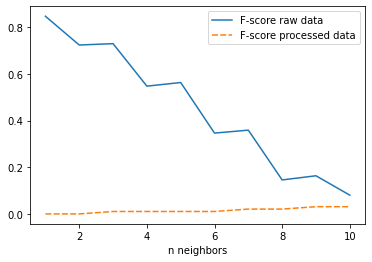

In [747]:
%%time

# Selection of neighbors and comparison of raw data with processed
knn_res_metrics = pd.DataFrame(columns = ['n neighbors', 'F-score raw data', 'F-score processed data'])

# Evaluate models for the appropriate number of neighbors
for n in tqdm(range(1, 10 + 1)):
    KNN1 = KNeighborsClassifier(n_neighbors=n)
    KNN2 = KNeighborsClassifier(n_neighbors=n)
    f_score = f1_score(KNN1.fit(X_train, y_train).predict(X_val), y_val)
    f_score_p = f1_score(KNN1.fit(X_train_over, y_train_over).predict(X_val), y_val)

    knn_res_metrics = knn_res_metrics.append({'n neighbors': n, 
                                              'F-score raw data': f_score, 
                                              'F-score processed data': f_score_p}, 
                                             ignore_index = True)

knn_res_metrics.set_index('n neighbors', inplace=True)


print(f"Max score:\n{knn_res_metrics.max()}\n")
sns.lineplot(data = knn_res_metrics)
knn_res_metrics.head(3)

#### We can see that the best result is for 1 neighbor, so oversampling not require

### Build f1 scores for 1 neighbor

Accuracy score: 0.993
Precision score: 0.886
Recall score: 0.812
F-score: 0.847

Max F1-Score: 0.847 (threshold: 0.0)



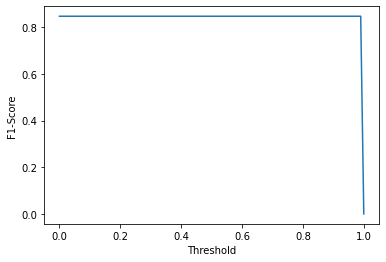

In [746]:
# Train model
kneighbors_model = KNeighborsClassifier(n_neighbors=1)
kneighbors_model.fit(X_train, y_train)

# Result
y_pred = kneighbors_model.predict_proba(X_val)
print_scores(y_val, y_pred[:, 1])

#### The best result is 0.847 (F1 score)

# Support Vector Classification

### Split and processed data

In [47]:
y = df2['gb']
X = df2.iloc[:, :-2]

print("X shape:")
print(X.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

print("\ny_train distribution:")
print(y_train.value_counts())
print("\ny_val distribution:")
print(y_val.value_counts())

# StandardScaler
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

# Normalizer
# normalizer = Normalizer().fit(X_train)
# X_train = normalizer.transform(X_train)
# X_val = normalizer.transform(X_val)

# MinMaxScaler
# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

X shape:
(26824, 323)

y_train distribution:
0    18374
1      402
Name: gb, dtype: int64

y_val distribution:
0    7857
1     191
Name: gb, dtype: int64


### Train the SVC model

In [48]:
%%time

# Train model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Result
y_pred = svm_model.predict(X_val)
print_scores(y_val, y_pred)

Accuracy score: 0.977
Precision score: 1.0
Recall score: 0.01
F-score: 0.021
CPU times: user 5.28 s, sys: 98 ms, total: 5.38 s
Wall time: 5.41 s


# Decision Tree

### Split and processed data

In [748]:
y = df2['gb']
X = df2.iloc[:, :-2]

print("X shape:")
print(X.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

print("\ny_train distribution:")
print(y_train.value_counts())
print("\ny_val distribution:")
print(y_val.value_counts())

# StandardScaler
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

# Normalizer
# normalizer = Normalizer().fit(X_train)
# X_train = normalizer.transform(X_train)
# X_val = normalizer.transform(X_val)

# MinMaxScaler
# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

X shape:
(26824, 323)

y_train distribution:
0    18374
1      402
Name: gb, dtype: int64

y_val distribution:
0    7857
1     191
Name: gb, dtype: int64


### Train the DecisionTreeClassifier

Accuracy score: 0.981
Precision score: 0.594
Recall score: 0.613
F-score: 0.603

Max F1-Score: 0.603 (threshold: 0.0)

CPU times: user 4.27 s, sys: 27.3 ms, total: 4.3 s
Wall time: 4.3 s


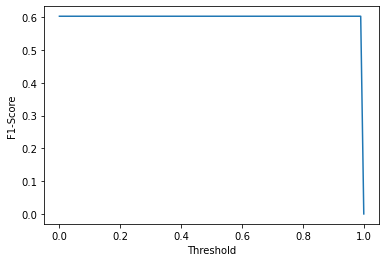

In [749]:
%%time

# Train model
dtc_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_model.fit(X_train, y_train)

# Result
y_pred = dtc_model.predict_proba(X_val)
print_scores(y_val, y_pred[:, 1])

# Random Forest

### Split and processed data

In [750]:
y = df2['gb']
X = df2.iloc[:, :-2]

print("X shape:")
print(X.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

print("\ny_train distribution:")
print(y_train.value_counts())
print("\ny_val distribution:")
print(y_val.value_counts())

X shape:
(26824, 323)

y_train distribution:
0    18374
1      402
Name: gb, dtype: int64

y_val distribution:
0    7857
1     191
Name: gb, dtype: int64


### Train the RandomForestClassifier

In [751]:
%%time

# Train model
rfc_model = RandomForestClassifier(n_estimators=200, 
                                   max_depth=40, 
                                   random_state=RANDOM_STATE)
rfc_model.fit(X_train, y_train)

# Result
y_pred = rfc_model.predict(X_val)
print_scores(y_val, y_pred)

Accuracy score: 0.987
Precision score: 1.0
Recall score: 0.435
F-score: 0.606
CPU times: user 20.5 s, sys: 155 ms, total: 20.7 s
Wall time: 20.9 s


# Dense neural network

### Split and processed data

In [752]:
y = df2['gb']
X = df2.iloc[:, :-2]

print("X shape:")
print(X.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size = 0.7, 
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

print("\ny_train distribution:")
print(y_train.value_counts())
print("\ny_val distribution:")
print(y_val.value_counts())

StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Normalizer
# normalizer = Normalizer().fit(X_train)
# X_train = normalizer.transform(X_train)
# X_val = normalizer.transform(X_val)

# MinMaxScaler
# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

# Random oversampling
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

print("\ny_train_over:")
print(y_train_over.value_counts())

# SMOTE (For KNeighborsClassifier result was worsened)
# smote = SMOTE(sampling_strategy='minority')
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print("\ny_train_smote:")
# print(y_train_smote.value_counts())

X shape:
(26824, 323)

y_train distribution:
0    18374
1      402
Name: gb, dtype: int64

y_val distribution:
0    7857
1     191
Name: gb, dtype: int64

y_train_over:
1    18374
0    18374
Name: gb, dtype: int64


In [753]:
# Create NN model
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(1028, activation='relu', input_shape=(X_train.shape[1], )))
nn_model.add(keras.layers.Dropout(0.5))
nn_model.add(keras.layers.Dense(512, activation='relu'))
nn_model.add(keras.layers.Dropout(0.5))
nn_model.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model.compile(optimizer='rmsprop', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', 'Precision', 'Recall'])
nn_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 1028)              333072    
_________________________________________________________________
dropout_22 (Dropout)         (None, 1028)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               526848    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 513       
Total params: 860,433
Trainable params: 860,433
Non-trainable params: 0
_________________________________________________________________


In [754]:
# model training
model_history_nn = nn_model.fit(X_train, 
                                y_train, 
                                batch_size=512, 
                                epochs=10, 
                                validation_data=(X_val, y_val))

Epoch 1/10
37/37 [==============================] - 2s 25ms/step - loss: 0.2509 - accuracy: 0.9025 - precision: 0.0254 - recall: 0.0874 - val_loss: 0.0807 - val_accuracy: 0.9769 - val_precision: 0.5610 - val_recall: 0.1204
Epoch 2/10
37/37 [==============================] - 1s 19ms/step - loss: 0.0668 - accuracy: 0.9816 - precision: 0.5717 - recall: 0.1128 - val_loss: 0.0719 - val_accuracy: 0.9790 - val_precision: 0.9231 - val_recall: 0.1257
Epoch 3/10
37/37 [==============================] - 1s 17ms/step - loss: 0.0517 - accuracy: 0.9833 - precision: 0.7695 - recall: 0.2711 - val_loss: 0.0691 - val_accuracy: 0.9788 - val_precision: 0.5515 - val_recall: 0.5602
Epoch 4/10
37/37 [==============================] - 1s 17ms/step - loss: 0.0444 - accuracy: 0.9844 - precision: 0.7328 - recall: 0.4160 - val_loss: 0.0585 - val_accuracy: 0.9836 - val_precision: 0.7611 - val_recall: 0.4503
Epoch 5/10
37/37 [==============================] - 1s 17ms/step - loss: 0.0364 - accuracy: 0.9903 - precisi

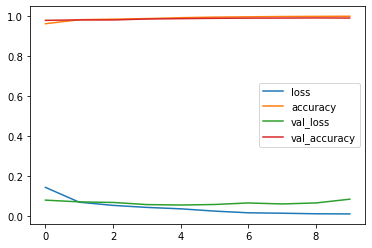

In [755]:
ax = sns.lineplot(range(len(model_history_nn.history['loss'])), model_history_nn.history['loss'])
sns.lineplot(range(len(model_history_nn.history['accuracy'])), model_history_nn.history['accuracy'], ax = ax)
sns.lineplot(range(len(model_history_nn.history['val_loss'])), model_history_nn.history['val_loss'], ax = ax)
sns.lineplot(range(len(model_history_nn.history['val_accuracy'])), model_history_nn.history['val_accuracy'], ax = ax)
ax.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy']);

Accuracy score: 0.988
Precision score: 0.953
Recall score: 0.534
F-score: 0.685

Max F1-Score: 0.771 (threshold: 0.121)



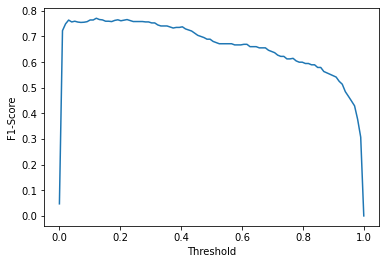

In [756]:
y_pred = nn_model.predict(X_val)
print_scores(y_val, y_pred, is_proba=True)

# The best result is 0.847 for KNeighborsClassifier